## Регрессия
### Цель
Ваша задача — предсказать цену продажи каждого дома. Для каждого идентификатора в тестовом наборе вам необходимо предсказать значение переменной SalePrice. 

Метрическая
Заявки оцениваются по среднеквадратичной ошибке (RMSE)  между логарифмом прогнозируемого значения и логарифмом наблюдаемой цены продажи. (Логистограммы означают, что ошибки в прогнозировании дорогих и дешевых домов одинаково повлияют на результат.)

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import pandas as pd
import numpy as np

In [115]:
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform, norm

In [116]:
from matplotlib import pyplot as plt 
import seaborn as sns

In [117]:
import xgboost as xgb
from catboost import CatBoostRegressor

In [118]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [119]:
from helper.plots import feature_plots
from helper.utils import data_tools

In [120]:
from Baseline import get_baseline
from Preproccesing import Evaluate, Action

In [121]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Описание набора данных
#### Описания файлов

* train.csv — обучающий набор
* test.csv — тестовый набор
* data_description.txt — полное описание каждого столбца, изначально подготовленное Дином Де Коком, но слегка отредактированное, чтобы соответствовать названиям столбцов, используемым здесь
* sample_submission.csv — эталонный отчет, полученный на основе линейной регрессии по году и месяцу продажи, площади участка и количеству спален.

#### Поля данных:

| Column Name     | Translation Name                                                  |
|-----------------|-------------------------------------------------------------------|
| SalePrice       |Цена продажи недвижимости в долларах                               | 
| MSSubClass      |Класс здания                                                       |
| MSZoning        |Общая классификация зонирования                                    |
| LotFrontage     |Линейные футы улицы, прилегающей к участку                         |
| LotArea         |Размер участка в квадратных футах                                  | 
| Street          |Тип подъездной дороги                                              |
| Alley           |Тип доступа к аллее                                                |
| LotShape        |Общая форма участка                                                |
| LandContour     |Ровность участка                                                   |
| Utilities       |Тип доступных коммунальных услуг                                   |
| LotConfig       |Конфигурация лота                                                  |
| LandSlope       |Уклон участка                                                      |
| Neighborhood    |Физические местоположения в пределах города Эймс                   |
| Condition1      |Близость к главной дороге или железной дороге                      |
| Condition2      |Близость к главной дороге или железной дороге (если есть вторая)   |
| BldgType        |Тип жилища                                                         |
| HouseStyle      | Стиль жилища                                                      |
| OverallQual     |Общее качество материалов и отделки                                |
| OverallCond     |Общая оценка состояния                                             |
| YearBuilt       |Первоначальная дата постройки                                      |
| YearRemodAdd    |Дата реконструкции                                                 |
| RoofStyle       |Тип крыши                                                          | 
| RoofMatl        |Кровельный материал                                                |
| Exterior1st     |Внешняя отделка дома                                               |
| Exterior2nd     |Внешняя отделка дома (если используется более одного материала)    |
| MasVnrType      |Тип облицовки каменной кладкой                                     |
| MasVnrArea      |Площадь облицовки каменной кладкой в ​​квадратных футах              |
| ExterQual       |Качество внешнего материала                                        |
| ExterCond       |Текущее состояние материала снаружи                                |
| Foundation      |Тип фундамента                                                     |
| BsmtQual        |Высота подвала                                                     |
| BsmtCond        |Общее состояние подвала                                            |
| BsmtExposure    |Стены подвала на уровне выхода или сада                            |
| BsmtFinType1    |Качество отделки подвала                                           |
| BsmtFinSF1      |Тип 1, готовые квадратные футы                                     |
| BsmtFinType2    |Качество второй обработанной области (если присутствует)           |
| BsmtFinSF2      |Тип 2, готовые квадратные футы                                     |
| BsmtUnfSF       |Неотделанная площадь подвала в квадратных футах                    |
| TotalBsmtSF     |Общая площадь подвала в квадратных футах                           |
| Heating         |Тип отопления                                                      |
| HeatingQC       |Качество и состояние отопления                                     |
| CentralAir      |Центральное кондиционирование воздуха                              |
| Electrical      |Электрическая система                                              |
| 1stFlrSF        |Площадь первого этажа (квадратные футы)                            |
| 2ndFlrSF        |Площадь второго этажа (квадратные футы)                            |
| LowQualFinSF    |Низкое качество отделки квадратных футов (все этажи)               |
| GrLivArea       |Жилая площадь над уровнем земли (квадратные футы)                  |
| BsmtFullBath    |Ванные комнаты в подвале                                           |
| BsmtHalfBath    |Полуванные в подвале                                               |
| FullBath        |Полноценные ванные комнаты выше уровня земли                       |
| HalfBath        |Полуванны выше уровня земли                                        |
| Bedroom         |Количество спален над цокольным этажом                             |
| Kitchen         |Количество кухонь                                                  |
| KitchenQual     |Качество кухни                                                     |
| TotRmsAbvGrd    |Общее количество комнат выше уровня земли (без учета ванных комнат)|
| Functional      |Оценка функциональности дома                                       |
| Fireplaces      |Количество каминов                                                 |
| FireplaceQu     |Качество камина                                                    |
| GarageType      |Расположение гаража                                                |
| GarageYrBlt     |Год постройки гаража                                               |
| GarageFinish    |Внутренняя отделка гаража                                          |
| GarageCars      |Размер гаража в зависимости от вместимости автомобиля              |
| GarageArea      |Площадь гаража в квадратных футах                                  |
| GarageQual      |Качество гаража                                                    |
| GarageCond      |Состояние гаража                                                   |
| PavedDrive      |Асфальтированная подъездная дорога                                 |
| WoodDeckSF      |Площадь деревянной террасы в квадратных футах                      |
| OpenPorchSF     |Площадь открытой веранды в квадратных футах                        |
| EnclosedPorch   |Площадь закрытой веранды в квадратных футах                        |
| 3SsnPorch       |Площадь крыльца, рассчитанного на три сезона, в квадратных футах   |
| ScreenPorch     |Площадь веранды в квадратных футах                                 |
| PoolArea        |Площадь бассейна в квадратных футах                                |
| PoolQC          |Качество пула                                                      |
| Fence           |Качество забора                                                    |
| MiscFeature     |Разные функции, не охваченные другими категориями                  |
| MiscVal         |$Value разного признака                                            |
| MoSold          |Месяц продаж                                                       |
| YrSold          |Год продажи                                                        |
| SaleType        |Тип продажи                                                        |
| SaleCondition   |Состояние продажи                                                  |

Зафиксируем наши испытания, создав переменную для **random_state**.

In [122]:
SEED = 42

### 1. Загрузка данных

Загрузим датасет, который представлен в виде **train** и **test**.

In [123]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [124]:
print(f'Размер train: {train.shape}')
print(f'Размер test: {test.shape}')

Размер train: (1460, 81)
Размер test: (1459, 80)


Заметим, что **отсутствует некий столбец в test** и предварительно можно оценить что это `SalePrice` - целевая переменная.

In [125]:
missing_columns = set(train.columns) - set(test.columns)
missing_columns = ", ".join(missing_columns)
print(missing_columns)

SalePrice


Т.к. **в тесте отсутствует целевая переменная**, то эти данные можно использовать только в kaggle, поэтому будем работать с трейном.

In [126]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [127]:
train.tail(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [128]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Максимальное количество данных 1460, наблюдаем большое количество пропущенных значений, которые надо преобработать, при этом первично можно оценить, что тип данных указан правильно. Есть фичи с сильными повреждениями в данных, поэтому возможно придется более детально их рассмотреть.

Перейдем к EDA.

### 2. Разведочный анализ данных (EDA)

#### 2.1. Проверка на дубликаты

Необходимо проверить данные на дубликаты, но скорее всего они отсутствуют, т.к. проверяем только 7 строк (по минимальному в датасете).

In [129]:
print(f'Количество дубликатов в данных: {train.duplicated().sum()}')

Количество дубликатов в данных: 0


Исключим фичи с редкими данными и с уникальными значениями.

In [130]:
neg_columns = ['PoolQC', 'MiscFeature', 'Fence','FireplaceQu', 'Id']
duplic_columns = [col for col in train.columns if col not in neg_columns]

In [131]:
print(f'Количество дубликатов в данных: {train[duplic_columns].duplicated().sum()}')

Количество дубликатов в данных: 0


Дубликаты отсутствуют, проверим пропущенные значения.

#### 2.2. Проверка на пропущенные значения

Проверим **количество и долю пропущенных значений.**

In [132]:
missing_value = data_tools.DataPreprocessor(train).get_missing()
miss_ratio = data_tools.DataPreprocessor(train).get_missing_ratio()

missing = pd.concat([missing_value , miss_ratio], axis=1)
missing.columns = ['count', 'ratio']

In [133]:
display(missing)

,count,ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


Топ 7 фичей с пропусков более 10%, поэтому стоит обратить на них особое внимание.

##### 2.3. Оценка типов данных

Выясним какие столбцы с категориальными переменными, а какие с количественными.

In [134]:
numeric_columns_eda = train.select_dtypes(include=['int', 'float']).columns.to_list()
categorical_columns_eda = train.select_dtypes(exclude=['int', 'float']).columns.to_list()

Рассмотрим детальнее категориальные фичи.

In [135]:
train[categorical_columns_eda].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


##### Краткая характеристика категориальных переменных:

| Column Name   | Translation Name      | Column Result                                                                                                                   |
|---------------|-------------|--------------------------------------------------------------------------------------------------------------------------|
| MSZoning       |Общая классификация зонирования |Данные в норме.|
| Street     |Тип подъездной дороги |В данных количество Pave 1454 из 1460, поэтому можно удалить этот столбец.|
| Alley    |Тип доступа к аллее |Данных сильно не хватает, но часть можно попробовать восстановить.|
| LotShape   |Общая форма участка | Данные в норме.|
| LandContour     |Общая оценка состояния | Данные в норме.|
| Utilities       |Тип доступных коммунальных услуг | В данных количество AllPub 1459 из 1460, поэтому можно удалить этот столбец.|
| LotConfig     |Конфигурация лота | Данные в норме.|
| LandSlope    |Уклон участка | Данные в норме.|
| Neighborhood   |Физические местоположения в пределах города Эймс | Данные в норме.|
| Condition1     |Близость к главной дороге или железной дороге | Данные в норме.|
| Condition2       |Близость к главной дороге или железной дороге (если есть вторая) | Данные в норме.|
| BldgType     |Тип жилища | Данные в норме.|
| HouseStyle    |Стиль жилища | Данные в норме.|
| RoofStyle   |Тип крыши | Данные в норме.|
| RoofMatl     |Кровельный материал | Данные в норме.|
| Exterior1st       |Внешняя отделка дома | Данные в норме.|
| Exterior2nd     |Внешняя отделка дома (если используется более одного материала) | Данные в норме.|
| MasVnrType   |Тип облицовки каменной кладкой | Данные в норме. Можно восстановить.|
| ExterQual     |Качество внешнего материала | Данные в норме.|
| ExterCond     |Текущее состояние материала снаружи | Данные в норме.|
| Foundation     |Тип фундамента | Данные в норме.|
| BsmtQual     |Высота подвала | Данные в норме. Можно восстановить.|
| BsmtCond     |Общее количество комнат выше уровня земли | Данные в норме. Можно восстановить.|
| BsmtExposure     |Стены подвала на уровне выхода или сада | Данные в норме. Можно восстановить.|
| BsmtFinType1     |Качество отделки подвала | Данные в норме. Можно восстановить.|
| BsmtFinType2     |Качество второй обработанной области (если присутствует) |Данные в норме. Можно восстановить.|
| Heating     |Тип отопления |Данные в норме.|
| HeatingQC     |Качество и состояние отопления |Данные в норме.|
| CentralAir     |Центральное кондиционирование воздуха |Данные в норме.|
| Electrical     |Электрическая система |Данные в норме, но есть один пропуск.|
| KitchenQual     |Качество кухни | Данные в норме.|
| Functional     |Оценка функциональности дома | Данные в норме.|
| FireplaceQu     |Качество камина |Данные в норме. Можно восстановить.|
| GarageType     |Расположение гаража | Данные в норме. Можно восстановить.|
| GarageFinish     |Внутренняя отделка гаража | Данные в норме. Можно восстановить.|
| GarageQual     |Качество гаража | Данные в норме. Можно восстановить.|
| GarageCond     |Состояние гаража | Данные в норме. Можно восстановить.|
| PavedDrive     |Асфальтированная подъездная дорога | Данные в норме.|
| Fence     |Качество забора | Данных сильно не хватает, но скорее всего пропуски - отсутствие забора.|
| SaleType     |Тип продажи | Данные в норме.|
| SaleCondition     |Состояние продажи | Данные в норме.|

Рассмотрим детальнее количественные фичи.

In [136]:
train[numeric_columns_eda].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


##### Краткая характеристика количественных переменных:

| Column Name   | Translation Name      | Column Result                                                                                                                   |
|---------------|-------------|--------------------------------------------------------------------------------------------------------------------------|
| MSSubClass       |Класс здания | В целом выглядит нормально, но стоит проверить данные на максимуме, т.к. наблюдается большое расхождение между 75% и max.|
| LotFrontage     |Линейные футы улицы, прилегающей к участку | Так же как и в классе здания надо проверить расхождение между 75% и max.|
| LotArea    |Размер участка в квадратных футах | Разница просто невероятная между 75% и max, что свидетельствует о возможном выбросе.|
| OverallQual   |Общее качество материалов и отделки | Данные в норме.|
| OverallCond     |Общая оценка состояния | Данные в норме.|
| YearBuilt       |Первоначальная дата постройки | Данные в норме.|
| YearRemodAdd     |Дата реконструкции | Данные в норме, но стоит проверить, чтобы дата реконструкции не была меньше, чем год постройки.|
| MasVnrArea    |Площадь облицовки каменной кладкой в ​​квадратных футах | Стоит проверить данные на максимуме, т.к. наблюдается большое расхождение между 75% и max.|
| BsmtFinSF1   |Качество отделки подвала | Стоит проверить данные на максимуме, т.к. наблюдается большое расхождение между 75% и max.|
| BsmtFinSF2     |Качество второй обработанной области | Стоит проверить данные на максимуме, т.к. наблюдается большое расхождение между 75% и max.|
| BsmtUnfSF       |Неотделанная площадь подвала в квадратных футах | Данные в норме.|
| TotalBsmtSF     |Общая площадь подвала в квадратных футах | Данные в норме.|
| 1stFlrSF    |Площадь первого этажа | Данные в норме.|
| 2ndFlrSF   |Качество второй обработанной области | Данные в норме.|
| LowQualFinSF     |Низкое качество отделки квадратных футов | Низкое качество отделки квадратных футов - Стоит проверить данные на максимуме, т.к. наблюдается большое расхождение между 75% и max.|
| GrLivArea       |Жилая площадь над уровнем земли | Данные в норме.|
| BsmtFullBath     |Ванные комнаты в подвале | В max видно 3 ванны в подвале, что можно поставить под сомнение в истинности данных.|
| BsmtHalfBath   |Полуванные в подвале | Данные в норме.|
| FullBath     |Полноценные ванные комнаты выше уровня земли | Возникает избыточных в этих, поэтому стоит от них избавиться.|
| HalfBath     |Полуванны выше уровня земли | Так же избавиться от данных, т.к. они избыточны.|
| BedroomAbvGr     | | Данные в норме.|
| KitchenAbvGr     | | Данные в норме.|
| TotRmsAbvGrd     |Общее количество комнат выше уровня земли | Данные в норме.|
| Fireplaces     |Количество каминов | Данные в норме.|
| GarageYrBlt     |Год постройки гаража | Данные в норме.|
| GarageCars     |Размер гаража в зависимости от вместимости автомобиля |Данные в норме.|
| GarageArea     |Площадь гаража в квадратных футах |Данные в норме.|
| WoodDeckSF     |Площадь деревянной террасы в квадратных футах |Данные в норме.|
| OpenPorchSF     |Площадь открытой веранды в квадратных футах |Данные в норме.|
| EnclosedPorch     |Площадь закрытой веранды в квадратных футах |Стоит проверить эти данные т.к. большинство значений в 0.|
| 3SsnPorch     |Площадь крыльца, рассчитанного на три сезона, в квадратных футах | Так же рассмотрим эти данные, т.к большинство значений в 0.|
| ScreenPorch     |Площадь веранды в квадратных футах | Так же большинство значений в 0.|
| PoolArea     |Площадь бассейна в квадратных футах |Так же большинство значений в 0.|
| MiscVal     |$Value разного признака | Этот столбец не несет в себе полезную информацию.|
| MoSold     |Месяц продаж | Данные в норме.|
| YrSold     |Год продажи | Данные в норме.|


### 3. Baseline

Для того чтобы понять, как обрабатывать пропуски над фичей, необходимо оценивать действия над ними. Для оценки наиболее результативных действий обучим начальную модель и после будем оценивать прирост по МАЕ. 

In [137]:
baseline_dummy = get_baseline(train, DummyRegressor())

In [138]:
print(f'МАЕ dummy: {baseline_dummy}')
print(f'Среднее значение: {round((train['SalePrice'].mean()), 2)}')
print(f'Относительная ошибка: {round((baseline_dummy / train['SalePrice'].mean()), 2) * 100}%')

МАЕ dummy: 62575.93
Среднее значение: 180921.2
Относительная ошибка: 35.0%


По Dummy сложно будет оценивать действия, т.к. модель ошибается на 35%, обучим более сильную модель, но без подбора гиперпараметров.

In [139]:
baseline_model = RandomForestRegressor(random_state=SEED)

In [140]:
baseline_forest = get_baseline(train, baseline_model)

In [141]:
print(f'МАЕ dummy: {baseline_forest}')
print(f'Среднее значение: {round((train['SalePrice'].mean()), 2)}')
print(f'Относительная ошибка: {round((baseline_forest / train['SalePrice'].mean()), 2) * 100}%')

МАЕ dummy: 17735.23
Среднее значение: 180921.2
Относительная ошибка: 10.0%


По этой ошибке можно оценить прирост метрики.

### 4. Детальное изучение признаков

`Id`

Видим, что **столбец не несет пользы**, т.к. он инкремент, поэтому нужно избавиться от него.

In [142]:
train = Action(train, 'Id').drop_data()

Удалена фича Id


`Street`

**Столбец с сильным перекосом** в данных, поэтому нужно использовать метод с лучшим приростом к метрике.

In [143]:
train['Street'].value_counts()

Street
Pave    1454
Grvl       6
Name: count, dtype: int64

In [144]:
train = Evaluate(train, 'Street', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17533.91
Drop,-3.28,17530.63
Fill,0.00,17533.91
Mapping,-45.67,17488.24
Bool,41.08,17574.99


Применен мэппинг на фиче Street


`Utilities`

**У столбца** по сути **только одно значение**, поэтому избавимся от него.

In [ ]:
train['Utilities'].value_counts()

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

In [146]:
train = Action(train, 'Utilities').drop_data()

Удалена фича Utilities


Оценим наши действия после предобработки сложных фичей.

In [147]:
interval_mae = get_baseline(train, baseline_model)
print(f'МАЕ Forest: {round((baseline_forest - interval_mae), 2)}')

МАЕ Forest: 271.62


##### 4.1. Категориальные переменные c пропусками

Теперь рассмотрим данные по **подвалу.** 

In [ ]:
bsmt = train.loc[train['BsmtQual'].isna(), ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',  'BsmtFinType2', 'TotalBsmtSF', 'SalePrice']]

display(bsmt.head(5))
print(f'Общая площадь подвала: {bsmt['TotalBsmtSF'].mean()}')

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,SalePrice
17,NaN,NaN,NaN,NaN,NaN,0,90000
39,NaN,NaN,NaN,NaN,NaN,0,82000
90,NaN,NaN,NaN,NaN,NaN,0,109900
102,NaN,NaN,NaN,NaN,NaN,0,118964
156,NaN,NaN,NaN,NaN,NaN,0,109500


Общая площадь подвала: 0.0


Общая площадь подвала равная нулю говорит о том, что в этих домах отсутствует подвал и поэтому надо пропуски заполнить меткой **No basement**.

In [149]:
bsmt_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',  'BsmtFinType2']

In [150]:
train[bsmt_columns] = train[bsmt_columns].fillna('No basement')

По такому же принципу **исследуем наличие гаража** в доме.

In [151]:
garage = train.loc[train['GarageType'].isna(), ['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType',  'GarageCars', 'GarageArea', 'SalePrice']]

display(garage.head(5))
print(f'Общая площадь гаража: {garage['GarageArea'].mean()}')

,GarageQual,GarageCond,GarageFinish,GarageType,GarageCars,GarageArea,SalePrice
39,NaN,NaN,NaN,NaN,0,0,82000
48,NaN,NaN,NaN,NaN,0,0,113000
78,NaN,NaN,NaN,NaN,0,0,136500
88,NaN,NaN,NaN,NaN,0,0,85000
89,NaN,NaN,NaN,NaN,0,0,123600


Общая площадь гаража: 0.0


По полученным данным видно, что в доме отсутствует гараж.

In [152]:
garage_columns = ['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']

In [153]:
train[garage_columns] = train[garage_columns].fillna('No garage')

Несмотря на то, что мы потеряли немного в качестве, выбранное действие над фичами с подвалом и гаражом являются единственными верными.

`PoolQC` 

In [154]:
missing[:5]

,count,ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260


Данные настолько **сильно повреждены**, что скорее всего восстановить не представляется возможным.

In [155]:
train = Evaluate(train, 'PoolQC', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17443.91
Drop,76.10,17520.01
Fill,216.51,17660.42
Mapping,86.83,17530.74
Bool,308.10,17752.01


Удалена фича PoolQC


`MiscFeature`

Рассмотрим эту фичу. Данные в ней **сильно повреждены** и доходят до 96%.

In [156]:
train['MiscFeature'].value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

In [157]:
train = Evaluate(train, 'MiscFeature', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17520.01
Drop,122.07,17642.08
Fill,133.97,17653.98
Mapping,51.87,17571.88
Bool,19.96,17539.97


Фича преобразована в булевый тип MiscFeature


`Alley`

In [158]:
_ = Evaluate(train, 'Alley', baseline_model).info()
del _

,Difference MAE,Final MAE
Baseline,0.00,17539.97
Drop,179.71,17719.68
Fill,-33.53,17506.44
Mapping,58.70,17598.67
Bool,99.56,17639.53


Фича Alley заполнена меткой


Любое действие приводит к сильному повышению метрики, поэтому попробуем получить прирост более детальной предобработкой.

In [159]:
train['Alley'].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

Grvl — Гравийный проезд.

Pave — Плиточный/асфальтированный проезд.

Сделаем срез по значениям.

In [160]:
data_grvl = train[train['Alley'] == train['Alley'].value_counts().index[0]]
data_pave = train[train['Alley'] == train['Alley'].value_counts().index[1]]

data_gp = pd.concat([data_grvl[:5], data_pave[:5]])
display(data_gp)

del data_gp

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Has_MiscFeature
21,45,RM,57.0,7449,0,Grvl,Reg,Bnk,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Unf,7,7,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,637,637,GasA,Ex,Y,FuseF,1108,0,0,1108,0,0,1,0,3,1,Gd,6,Typ,1,Gd,Attchd,1930.0,Unf,1,280,TA,TA,N,0,0,205,0,0,0,GdPrv,0,6,2007,WD,Normal,139400,0
79,50,RM,60.0,10440,0,Grvl,Reg,Lvl,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,5,6,1910,1981,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,440,440,GasA,Gd,Y,SBrkr,682,548,0,1230,0,0,1,1,2,1,TA,5,Typ,0,NaN,Detchd,1966.0,Unf,2,440,TA,TA,Y,74,0,128,0,0,0,MnPrv,0,5,2009,WD,Normal,110000,0
92,30,RL,80.0,13360,0,Grvl,IR1,HLS,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,5,7,1921,2006,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,Gd,BrkTil,Gd,TA,No,ALQ,713,Unf,0,163,876,GasA,Ex,Y,SBrkr,964,0,0,964,1,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1921.0,Unf,2,432,TA,TA,Y,0,0,44,0,0,0,NaN,0,8,2009,WD,Normal,163500,0
106,30,RM,60.0,10800,0,Grvl,Reg,Lvl,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,7,1885,1995,Mansard,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,0,Unf,0,641,641,GasA,Gd,Y,SBrkr,1047,0,0,1047,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1954.0,Unf,1,273,Fa,Fa,N,0,0,0,0,0,0,NaN,450,8,2007,WD,Normal,100000,1
204,50,RM,50.0,3500,0,Grvl,Reg,Lvl,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,7,1947,1950,Gable,CompShg,AsbShng,AsbShng,NaN,0.0,TA,TA,CBlock,TA,TA,No,LwQ,312,Unf,0,408,720,GasA,TA,Y,SBrkr,720,564,0,1284,0,0,1,1,2,1,TA,5,Typ,0,NaN,Detchd,1948.0,Unf,1,240,TA,TA,Y,0,35,0,0,0,0,MnWw,0,4,2009,WD,Normal,110000,0
30,70,C (all),50.0,8500,0,Pave,Reg,Lvl,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,NaN,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,TA,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,MnPrv,0,7,2008,WD,Normal,40000,0
56,160,FV,24.0,2645,0,Pave,Reg,Lvl,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,8,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,456.0,Gd,TA,PConc,Gd,TA,No,GLQ,649,Unf,0,321,970,GasA,Ex,Y,SBrkr,983,756,0,1739,1,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,1999.0,Fin,2,480,TA,TA,Y,115,0,0,0,0,0,NaN,0,8,2009,WD,Abnorml,172500,0
87,160,FV,40.0,3951,0,Pave,Reg,Lvl,Corner,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,Stone,76.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,612,612,GasA,Ex,Y,SBrkr,612,612,0,1224,0,0,2,1,2,1,Gd,4,Typ,0,NaN,Detchd,2009.0,RFn,2,528,TA,TA,Y,0,234,0,0,0,0,NaN,0,6,2009,New,Partial,164500,0
115,160,FV,34.0,3230,0,Pave,Reg,Lvl,Corner,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,1999,1999,Gable,CompShg,MetalSd,MetalSd,BrkFace,1129.0,TA,TA,PConc,Gd,TA,No,GLQ,419,Unf,0,310,729,GasA,Gd,Y,SBrkr,729,729,0,1458,0,0,2,1,2,1,TA,5,Typ,1,Fa,Detchd,1999.0,Unf,2,440,TA,TA,Y,0,32,0,0,0,0,NaN,0,6,2007,WD,Normal,176000,0
164,40,RM,40.0,5400,0,Pave,Reg,Lvl,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,7,1926,2004,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,BrkTil,TA,TA,Mn,LwQ,370,Unf,0,779,1149,GasA,Gd,Y,FuseA,1149,467,0,1616,0,0,2,0,3,1,Gd,5,Typ,0,NaN,Detchd,1926.0,Unf,1,216,TA,TA,Y,0,0,183,0,0,0,NaN,0,10,2007,WD,Normal,152000,0


Посмотрим разницу домов по общей классификации зонирования.

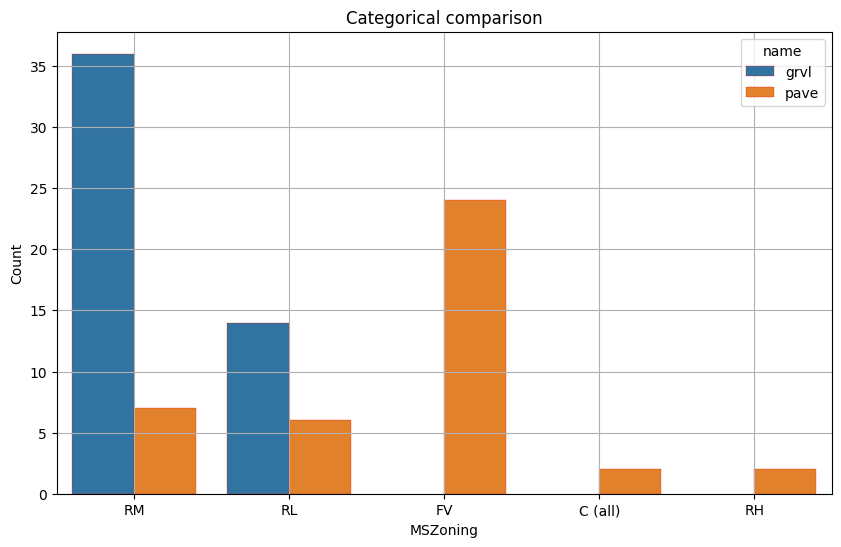

In [161]:
datasets_zone = {
    "grvl": data_grvl['MSZoning'],
    "pave": data_pave['MSZoning']
}

feature_plots.BuildHist(datasets_zone).categorical_hist()

del datasets_zone

Мы можем восстановить часть данных заполнив Alley со значением pave по MSZoning со значениями FV и RH.

In [162]:
train.loc[train['MSZoning'] == 'FV', 'Alley'] = 'Pave'
train.loc[train['MSZoning'] == 'RH', 'Alley'] = 'Pave'
train.loc[train['MSZoning'] == 'C (all)', 'Alley'] = 'Pave'

Рассмотрим возможность восстановления данных по году постройки.

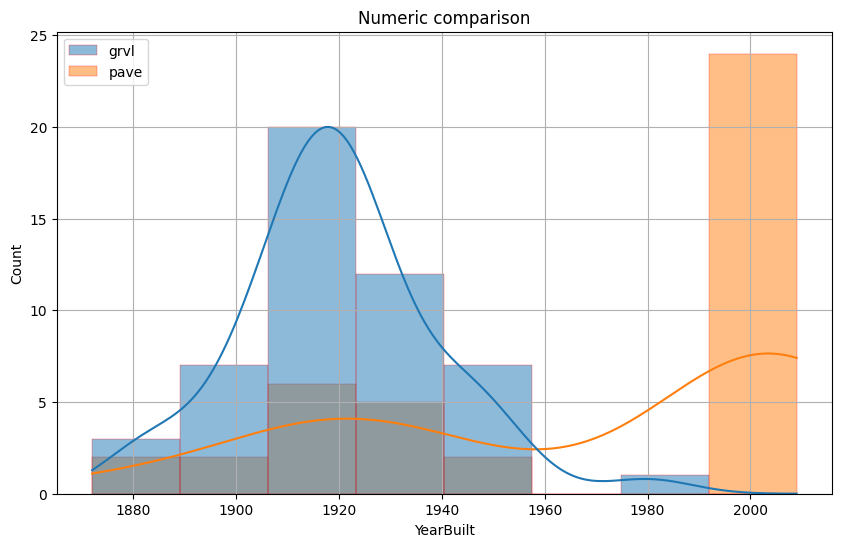

In [163]:
datasets_year = {
    "grvl": data_grvl['YearBuilt'],
    "pave": data_pave['YearBuilt']
}

feature_plots.BuildHist(datasets_year).numeric_plot()

del datasets_year

Заметим, что после 1990 года, с большой уверенностью, можем восстановить Alley со значением Pave.

In [164]:
train.loc[(train['YearBuilt'] >= 1990) & (train['Alley'].isna()), 'Alley'] = 'Pave'

Так же рассмотрим по году постройке гаража. 

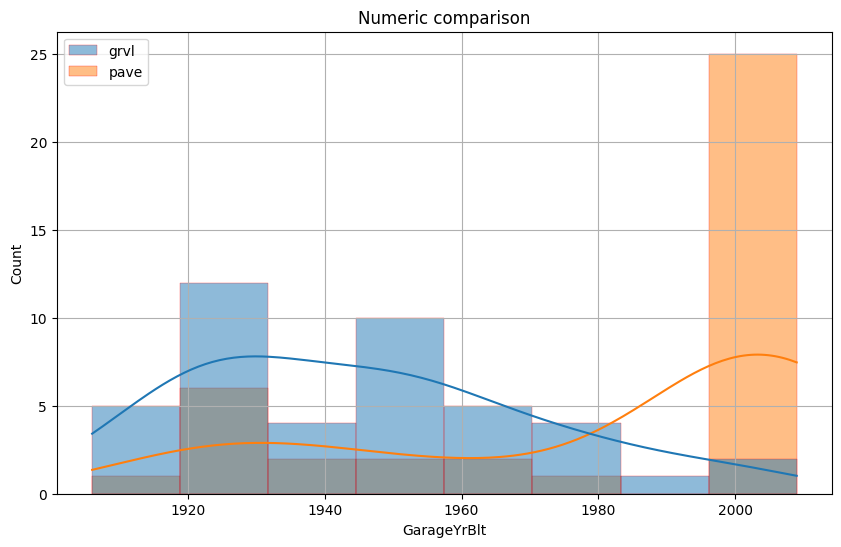

In [165]:
datasets_garage = {
    "grvl": data_grvl['GarageYrBlt'],
    "pave": data_pave['GarageYrBlt']
}

feature_plots.BuildHist(datasets_garage).numeric_plot()

del datasets_garage

Так же восстановим по гаражу после 2000 года.

In [166]:
train.loc[(train['GarageYrBlt'] >= 2000) & (train['Alley'].isna()), 'Alley'] = 'Pave'

Попробуем восстановить данные по соседям.

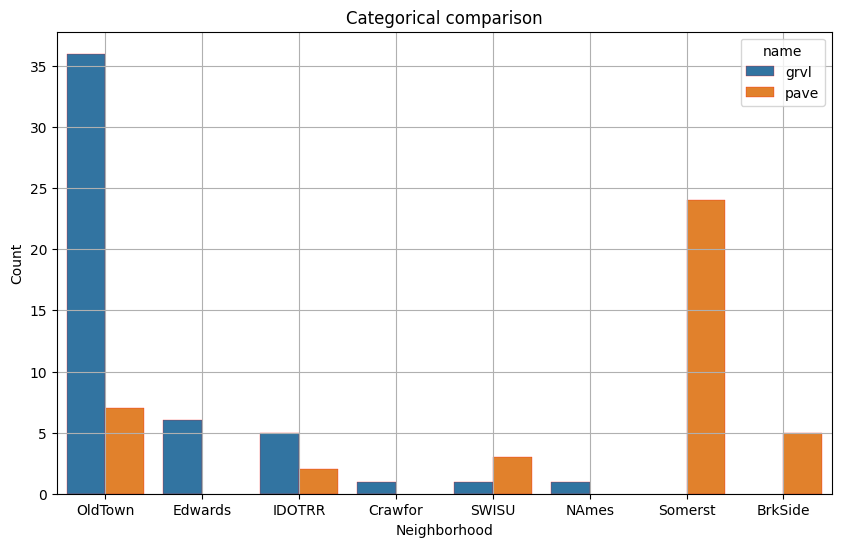

In [167]:
datasets_neighborhood = {
    "grvl": data_grvl['Neighborhood'],
    "pave": data_pave['Neighborhood']
}

feature_plots.BuildHist(datasets_neighborhood).categorical_hist()

del datasets_neighborhood

Восстановим данные там, где однозначено определено значение по столбцу.

In [168]:
train.loc[(train['Neighborhood'] == 'Crawfor') & (train['Alley'].isna()), 'Alley'] = 'Grvl'
train.loc[(train['Neighborhood'] == 'Edwards') & (train['Alley'].isna()), 'Alley'] = 'Grvl'
train.loc[(train['Neighborhood'] == 'NAmes') & (train['Alley'].isna()), 'Alley'] = 'Grvl'
train.loc[(train['Neighborhood'] == 'Somerst') & (train['Alley'].isna()), 'Alley'] = 'Pave'
train.loc[(train['Neighborhood'] == 'BrkSide') & (train['Alley'].isna()), 'Alley'] = 'Pave'

In [169]:
train = Evaluate(train, 'Alley', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17581.68
Drop,138.00,17719.68
Fill,11.76,17593.44
Mapping,2.32,17584.00
Bool,47.07,17628.75


Применен мэппинг на фиче Alley


В результате более тщательной предобратки получили MAE лучше, нежели используя стандартные методы.

`MasVnrType` - Тип облицовки каменной кладкой

In [170]:
train = Evaluate(train, 'MasVnrType', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17584.00
Drop,-3.25,17580.75
Fill,89.72,17673.72
Mapping,106.66,17690.66
Bool,68.86,17652.86


Удалена фича MasVnrType


Такой прирост по МАЕ говорит о том, что **фича неважна в данных**, поэтому дальнейшая предобработка по ней не требуется.

`Fence` - Забор

In [171]:
train['Fence'].value_counts()

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

MnPrv — среднее качество ограды.

GdPrv — хорошее качество ограды.

GdWo — хорошая ограда без покрытия (без покрытия или "без обработки").

MnWw — низкое качество ограды.

In [172]:
train = Evaluate(train, 'Fence', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17580.75
Drop,-51.29,17529.46
Fill,34.32,17615.07
Mapping,42.03,17622.78
Bool,60.00,17640.75


Удалена фича Fence


`FireplaceQu` - Качество камина

In [173]:
train['FireplaceQu'].value_counts()

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64

Gd — Good (хорошее качество камина).

TA — Typical Average (среднее стандартное качество камина).

Fa — Fair (небольшое ухудшение, камин в среднем состоянии).

Po — Poor (плохое качество камина).

Ex — Excellent (отличное качество камина).

In [174]:
train = Evaluate(train, 'FireplaceQu', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17529.46
Drop,-83.00,17446.46
Fill,73.30,17602.76
Mapping,147.48,17676.94
Bool,93.11,17622.57


Удалена фича FireplaceQu


Скорее всего пропуски в этих данных **означает отсутствие камина.**

In [176]:
#print(f'Среднее количество каминов: {train['Fireplaces'][train['FireplaceQu'].isna()].mean()}')

Гипотеза подтвердилась, поэтому **заполним меткой No Fireplace.**

In [177]:
#train['Fireplaces'] = train['Fireplaces'].fillna('No Fireplace')

`Electrical`

In [178]:
print(f'Количество пропущенных данных: {train['Electrical'].isna().sum()}')

Количество пропущенных данных: 1


В этой фиче пропущена одна строка, поэтому удалим ее.

In [179]:
train = train.dropna(subset=['Electrical'])

In [180]:
print(f'Количество пропущенных данных: {train['Electrical'].isna().sum()}')

Количество пропущенных данных: 0


**Итоговая метрика** после предобработки **категориальных** фичей.

In [181]:
categorical_mae = get_baseline(train, baseline_model)
print(f'МАЕ Forest: {categorical_mae}')
print(f'Разница MAE после преобработки: {round((baseline_forest - categorical_mae),2)}')

МАЕ Forest: 17488.03
Разница MAE после преобработки: 247.2


##### 4.2. Количественные переменные c пропусками

`LotFrontage` - Линейные футы улицы, прилегающей к участку

Посмотрим распредение LotFrontage.

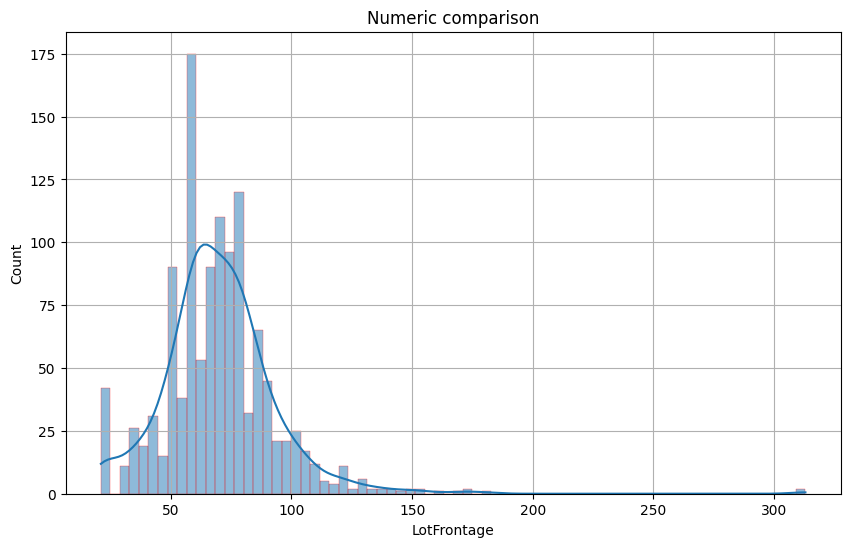

In [182]:
feature_plots.BuildHist(train['LotFrontage']).numeric_plot()

Так же посмотрим на выбросы.

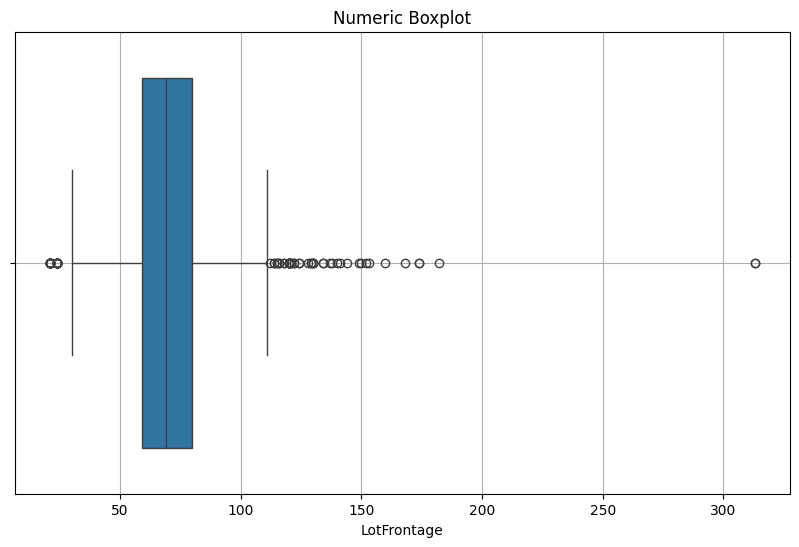

In [183]:
feature_plots.BuildHist(train['LotFrontage']).numeric_boxplot()

Так как датасет основан на данных США, то такие большие значения прилегающей улицы явление нормальное.

Осталось исследовать пропущенные данные.

In [184]:
print(f'Количество пропущенных данных: {train['LotFrontage'].isna().sum()}')

Количество пропущенных данных: 259


Заполним их средним значением.

In [185]:
_ = Evaluate(train, 'LotFrontage', baseline_model).info()
del _

,Difference MAE,Final MAE
Baseline,0.00,17488.03
Drop,-187.64,17300.39
Median,82.02,17570.05
Mean,-31.66,17456.37
Mode,-28.54,17459.49


Удалена фича LotFrontage


Заполним их средним значением.

In [186]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())

C:\Users\46120\AppData\Local\Temp\ipykernel_8140\917670201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())


In [187]:
print(f'Количество пропущенных данных: {train['LotFrontage'].isna().sum()}')

Количество пропущенных данных: 0


`MasVnrArea` - Площадь облицовки каменной кладкой в ​​квадратных футах  

Посмотрим распределение MasVnrArea.

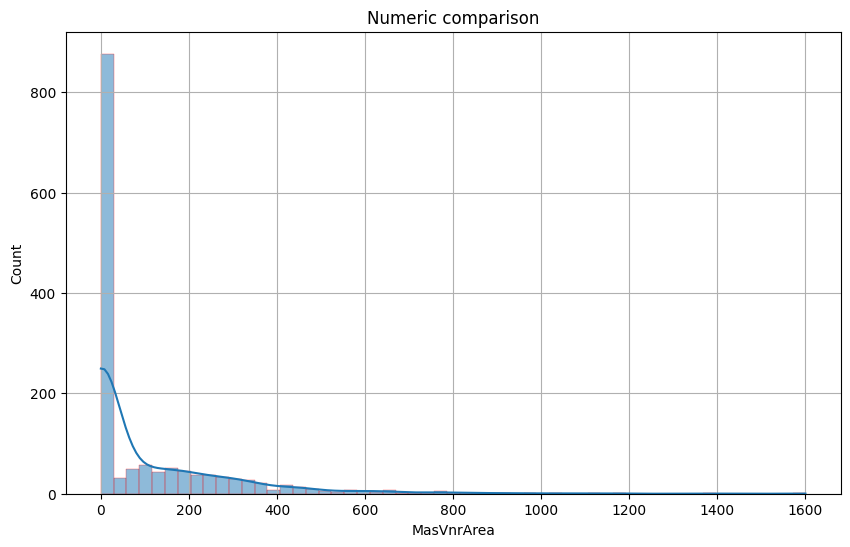

In [188]:
feature_plots.BuildHist(train['MasVnrArea']).numeric_plot()

Посмотрим выбросы MasVnrArea

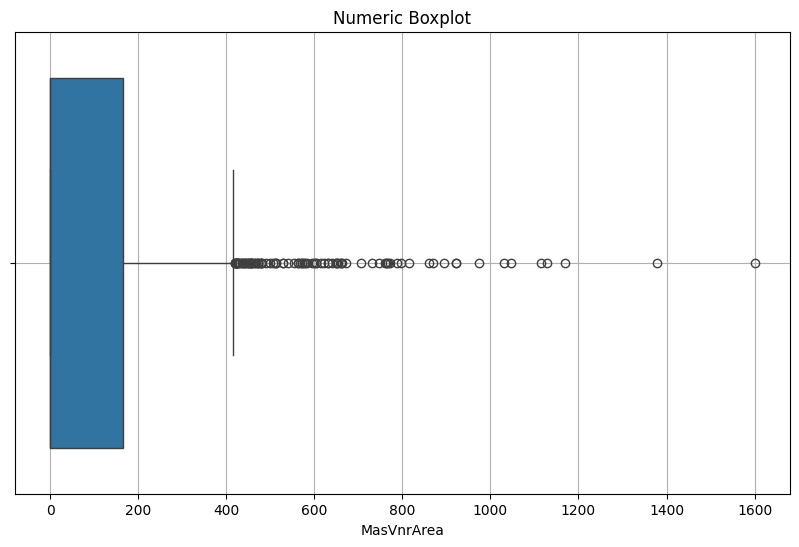

In [189]:
feature_plots.BuildHist(train['MasVnrArea']).numeric_boxplot()

Посмотрим параметры здания у которых MasVnrArea более 1000.

In [190]:
train.loc[train['MasVnrArea'] > 1000, ['MasVnrArea', 'LotArea', 'YearBuilt', 'SalePrice']]

,MasVnrArea,LotArea,YearBuilt,SalePrice
58,1031.0,13682,2006,438780
70,1115.0,13651,1973,244000
115,1129.0,3230,1999,176000
297,1600.0,7399,1997,239000
691,1170.0,21535,1994,755000
808,1047.0,13400,1966,159950
1169,1378.0,35760,1995,625000


Скорее всего данные с индексами 115 и 297 являются выбросами.

In [191]:
train = train.drop(index=[115, 297])

Теперь посмотрим пропущенные значения.

In [192]:
_ = Evaluate(train, 'MasVnrArea', baseline_model).info()
del _

,Difference MAE,Final MAE
Baseline,0.00,16350.51
Drop,-172.36,16178.15
Median,-200.90,16149.61
Mean,-0.43,16350.08
Mode,-200.90,16149.61


Фича MasVnrArea заполнена меткой


In [193]:
print(f'Количество пропущенных данных: {train['MasVnrArea'].isna().sum()}')

Количество пропущенных данных: 8


Удалим фичу.

In [194]:
train = Action(train, 'MasVnrArea').drop_data()

Удалена фича MasVnrArea


`GarageYrBlt` - Год постройки гаража

In [195]:
missing_year = train.loc[train['GarageYrBlt'].isna(), ['GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']]
missing_year.head(5)

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageCond,GarageYrBlt
39,0,0,No garage,No garage,No garage,No garage,NaN
48,0,0,No garage,No garage,No garage,No garage,NaN
78,0,0,No garage,No garage,No garage,No garage,NaN
88,0,0,No garage,No garage,No garage,No garage,NaN
89,0,0,No garage,No garage,No garage,No garage,NaN


In [196]:
print(f'Среднее значение GarageArea: {missing_year['GarageArea'].mean()}')
print(f'Среднее значение GarageCars: {missing_year['GarageCars'].mean()}')

Среднее значение GarageArea: 0.0
Среднее значение GarageCars: 0.0


Эти строки не представляют интереса.

In [197]:
_ = Evaluate(train, 'GarageYrBlt', baseline_model).info()
del _

,Difference MAE,Final MAE
Baseline,0.00,16178.15
Drop,25.82,16203.97
Median,-3.74,16174.41
Mean,-5.91,16172.24
Mode,166.62,16344.77


Применен мэппинг на фиче GarageYrBlt


In [198]:
train = train.dropna(subset=['GarageYrBlt'])

In [199]:
get_baseline(train, baseline_model)

18277.21

In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1376 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       1376 non-null   int64  
 1   MSZoning         1376 non-null   object 
 2   LotFrontage      1376 non-null   float64
 3   LotArea          1376 non-null   int64  
 4   Street           1376 non-null   int64  
 5   Alley            1376 non-null   int64  
 6   LotShape         1376 non-null   object 
 7   LandContour      1376 non-null   object 
 8   LotConfig        1376 non-null   object 
 9   LandSlope        1376 non-null   object 
 10  Neighborhood     1376 non-null   object 
 11  Condition1       1376 non-null   object 
 12  Condition2       1376 non-null   object 
 13  BldgType         1376 non-null   object 
 14  HouseStyle       1376 non-null   object 
 15  OverallQual      1376 non-null   int64  
 16  OverallCond      1376 non-null   int64  
 17  YearBuilt        13

### 5. Обучение моделей

##### 5.1. RandomForest

Целевая переменная в этом датасете распределена асимметрично — большинство домов стоят в диапазоне 100–250 тыс, но есть редкие дорогие дома за 600–700 тыс. Поэтому прологарифмируем её.

In [201]:
X, y = train.drop(columns=['SalePrice']), train['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [202]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

In [203]:
forest_params = {
    'reg__n_estimators' : randint(20, 700),
    'reg__max_depth' : randint(3, 20),
    'reg__min_samples_split': randint(2, 10),
    'reg__min_samples_leaf': randint(1, 4)
}

In [204]:
forest = RandomForestRegressor(n_jobs=-1)

In [205]:
forest_pipe = data_tools.PipelineManager(X_train, y_train, forest).train_model(forest_params)

Лучшие параметры модели: {'reg__max_depth': 18, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 4, 'reg__n_estimators': 554}


In [206]:
best_forest = forest_pipe.best_estimator_

In [207]:
forest_predict = np.expm1(best_forest.predict(X_val))
forest_mae = round(mean_absolute_error(np.expm1(y_val), forest_predict), 2)

print(f'MAE RandomForest: {forest_mae}')

MAE RandomForest: 19167.66


##### 5.2. XGBoost

In [208]:
xgb_params = {
    'reg__n_estimators' : randint(100, 1000),
    'reg__max_depth' : randint(3, 12),
    'reg__learning_rate' : uniform(0.01, 0.3)
}

In [209]:
xgb_model = xgb.XGBRegressor(random_state=SEED, n_jobs=-1)

In [210]:
xgb_pipe = data_tools.PipelineManager(X_train, y_train, xgb_model).train_model(xgb_params)

Лучшие параметры модели: {'reg__learning_rate': 0.28339160285602666, 'reg__max_depth': 3, 'reg__n_estimators': 970}


In [211]:
xgb_best = xgb_pipe.best_estimator_

In [212]:
xgb_predict = np.expm1(xgb_best.predict(X_val))
xgb_mae = round(mean_absolute_error(np.expm1(y_val), xgb_predict), 2)

print(f'MAE XGBoost: {xgb_mae}')

MAE XGBoost: 17802.49


#### 5.3 Catboost

In [213]:
cat_params = {
    'reg__n_estimators' : randint(100, 1000),
    'reg__max_depth' : randint(3, 12),
    'reg__learning_rate' : uniform(0.01, 0.3)
}

In [214]:
cat_model = CatBoostRegressor()

In [215]:
cat_pipe = data_tools.PipelineManager(X_train, y_train, cat_model).train_model(cat_params)

c:\Users\46120\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\46120\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\46120\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\46120\AppData\

0:	learn: 0.3516070	total: 12.5ms	remaining: 6.14s
1:	learn: 0.3281068	total: 14ms	remaining: 3.44s
2:	learn: 0.3082890	total: 15.3ms	remaining: 2.5s
3:	learn: 0.2908728	total: 16.6ms	remaining: 2.03s
4:	learn: 0.2764582	total: 17.6ms	remaining: 1.72s
5:	learn: 0.2645303	total: 18.9ms	remaining: 1.53s
6:	learn: 0.2528432	total: 20.2ms	remaining: 1.4s
7:	learn: 0.2425282	total: 21.3ms	remaining: 1.29s
8:	learn: 0.2318221	total: 22.2ms	remaining: 1.19s
9:	learn: 0.2212568	total: 23.1ms	remaining: 1.11s
10:	learn: 0.2125459	total: 24.1ms	remaining: 1.05s
11:	learn: 0.2053642	total: 24.9ms	remaining: 1000ms
12:	learn: 0.1977281	total: 25.8ms	remaining: 953ms
13:	learn: 0.1912271	total: 27ms	remaining: 925ms
14:	learn: 0.1860699	total: 28.1ms	remaining: 896ms
15:	learn: 0.1803070	total: 29ms	remaining: 866ms
16:	learn: 0.1757383	total: 29.9ms	remaining: 838ms
17:	learn: 0.1714598	total: 30.8ms	remaining: 813ms
18:	learn: 0.1686054	total: 31.6ms	remaining: 789ms
19:	learn: 0.1658632	total: 3

In [216]:
cat_best = cat_pipe.best_estimator_

In [217]:
cat_predict = np.expm1(cat_best.predict(X_val))
cat_mae = round(mean_absolute_error(np.expm1(y_val), cat_predict), 2)

print(f'MAE CatBoost: {cat_mae}')

MAE CatBoost: 16290.3


##### 5.4. Итоговая оценка на тестовой выборке

In [218]:
X_test = test
test_id = test['Id']

In [219]:
drop_columns = [col for col in X_test.columns if col not in X_train.columns]

In [220]:
X_test = X_test.drop(columns=drop_columns)

In [221]:
test_predict = np.expm1(cat_best.predict(X_test))

ValueError: columns are missing: {'Has_MiscFeature'}

In [ ]:
submission = pd.DataFrame({
    'Id': test_id,          
    'SalePrice': test_predict
})

NameError: name 'test_predict' is not defined

In [ ]:
submission.to_csv('predict.csv', index=False)

Оценка на Kaggle.

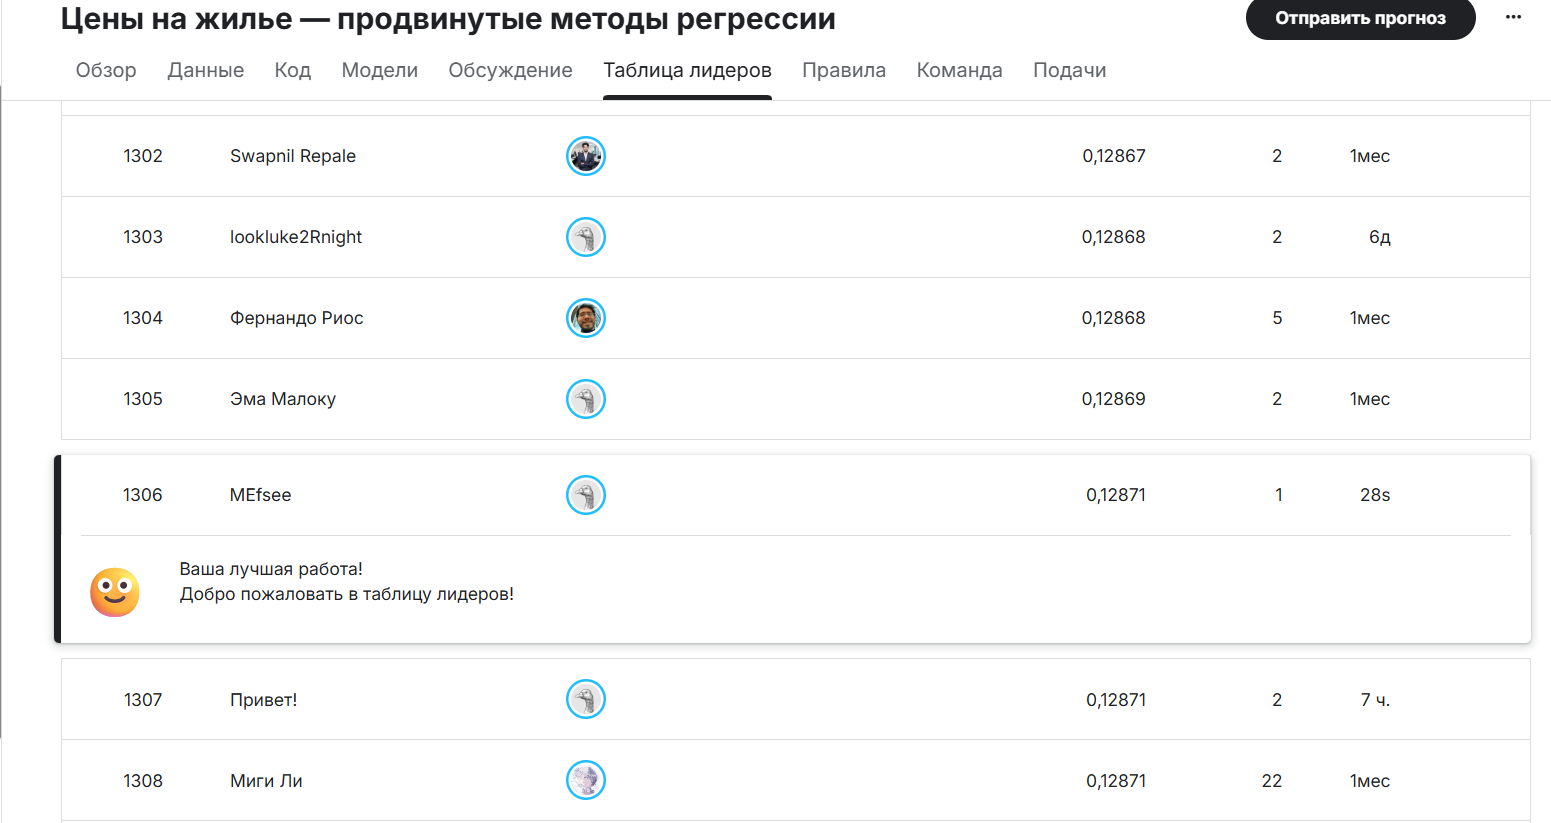

#### 6. Вывод 

In [ ]:
error = round(cat_mae / train['SalePrice'].mean(), 2) * 100
print(f'Итоговая ошибка модели в процентах: {error}%')

Итоговая ошибка модели в процентах: 8.0%


После обучения модели CatBoost с использованием регрессии для предсказания цен домов на основе датасета House Prices, была получена средняя абсолютная ошибка (MAE) на валидационном наборе данных:

MAE = 15247.21 долларов.

Это означает, что в среднем модель ошибается на 15247 доллар при предсказаниях цены домов.

Относительная ошибка составляет 8%

Это означает, что ошибка модели составляет около 8% от средней цены дома, что является отличным результатом для регрессионных моделей.